### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 6th at 11.59pm CT
---

## Only one problem this week

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import colormaps
import colorcet as cc
import cmasher as cmr

1. Use the following code snippet to read in SDSS galaxy color data.
<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?

In [2]:
data = np.load('/Users/sofimar/vu_classes/astr_8070_s24/coursework/homeworks/hw_data/hw8_data_1.npy')

In [3]:
data.dtype.names

('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')

In [4]:
u_g = data['u'] - data['g']
g_r = data['g'] - data['r']
r_i = data['r'] - data['i']
i_z = data['i'] - data['z']
redshift = data['redshift']
specclass = data['specClass']

2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.

Text(0, 0.5, 'u-g')

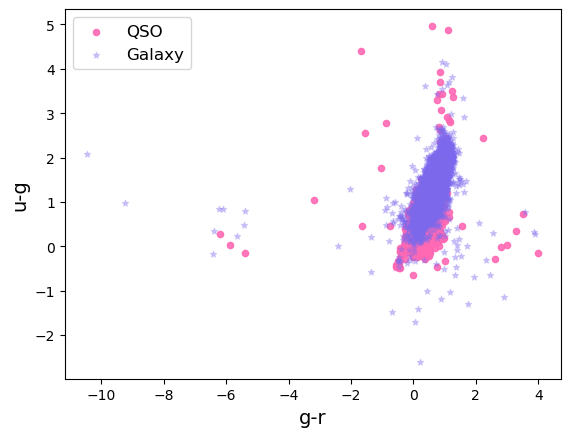

In [5]:
qso = specclass=='QSO'
gxy = specclass=='GALAXY'


plt.scatter(g_r[qso], u_g[qso], color='hotpink', label='QSO', s=20, alpha=0.9)
plt.scatter(g_r[gxy], u_g[gxy], color='mediumslateblue', label='Galaxy', alpha=0.3, s=20, marker='*')
plt.legend(fontsize=12)
plt.xlabel('g-r', fontsize=14)
plt.ylabel('u-g', fontsize=14)

SRT: The question included some plotting limits for the x and y axes that were to be applied to make the populations look clearer. -1 point.

3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X = np.array((u_g,g_r,r_i,i_z,redshift))
X = X.T
print(np.shape(X))

(50000, 5)


In [8]:
label = np.empty(50000)
for i in range(50000):
    if specclass[i]=='GALAXY':
        label[i] = 0
    else:
        label[i] = 1

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.2, random_state=42)

4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*

In [10]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve

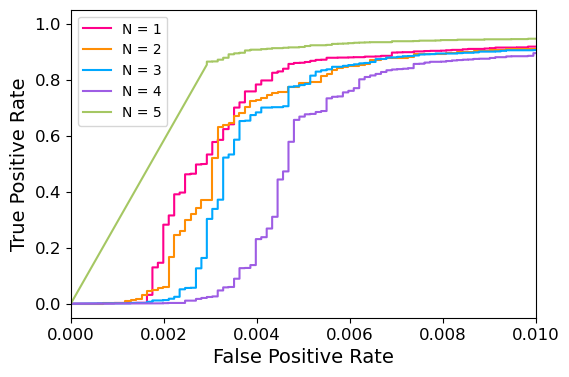

In [11]:
N = 5

rocx = []
rocy = []

clrs = ['#FF008B', '#FF8E05', '#00A8FF', '#9E5DE4', '#A5C763']

plt.figure(figsize=(6,4))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlim(0, 0.01)

for i in range(N):
    clf = GaussianNB()
    clf.fit(X_train[:,:i+1], y_train)
    y_prob = clf.predict_proba(X_test[:,:i+1])
    ytroc, yproc, thresh = roc_curve(y_test, y_prob[:,1])
    plt.plot(ytroc, yproc, color=clrs[i], label='N = '+str(i+1))
    plt.legend()
    rocx.append(ytroc)
    rocy.append(yproc)



SRT: Very good!

**The the TPR is maximized and the FPR is minimized when GNB runs on all 5 features**

5. Repeat (4) for Quadratic Discriminant Analysis. 

In [12]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

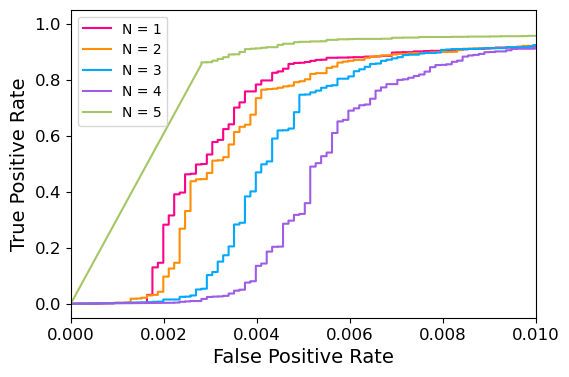

In [13]:
rocx_QDA = []
rocy_QDA = []

plt.figure(figsize=(6,4))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlim(0, 0.01)

for i in range(N):
    qda = QDA()
    qda.fit(X_train[:,:i+1], y_train)
    y_prob = qda.predict_proba(X_test[:,:i+1])
    ytroc, yproc, thresh = roc_curve(y_test, y_prob[:,1])
    plt.plot(ytroc, yproc, color=clrs[i], label='N = '+str(i+1))
    plt.legend()
    rocx_QDA.append(ytroc)
    rocy_QDA.append(yproc)

**Similar to GNB, the TPR is maximized and the FPR is minimized when QDA runs on all 5 features**

6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.

In [14]:
from astroML.classification import GMMBayes

In [15]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X[:,:-1], label, test_size=0.2, random_state=42)

In [16]:
rbw = colormaps['cet_CET_R3']
cm = rbw(np.linspace(0,1,10))

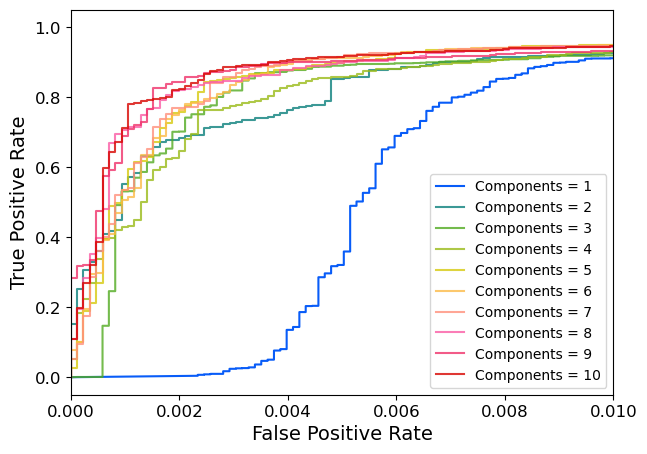

In [17]:
rocx_gmmb = []
rocy_gmmb = []

plt.figure(figsize=(7,5))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlim(0, 0.01)

ca = [1, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]

for i in range(10):
    gmmb = GMMBayes(i+1)
    gmmb.fit(X_train4,y_train4)
    yprob4 = gmmb.predict_proba(X_test4)
    gmmb_roc_x, gmmb_roc_y, gmmb_thresh = roc_curve(y_test4, yprob4[:,1])
    plt.plot(gmmb_roc_x, gmmb_roc_y, color=cm[i], label='Components = '+str(i+1), alpha=ca[i])
    plt.legend()
    rocx_gmmb.append(gmmb_roc_x)
    rocy_gmmb.append(gmmb_roc_y)

**9 components give the best performance**

SRT: I can't see how you've judged that. Was it quantitative? I notice that none of the rest of the solutions have quantitative assessments of the best classifer performance. The solution is to use the area under the ROC curve. -3 points.

7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 

**You can't go from 5 to 100 in steps of 10... so I'm doing 5 to 95 in steps of 10 which is arithmetically possible**

In [18]:
from sklearn.neighbors import KNeighborsClassifier

In [19]:
Ks = np.arange(5,100,10)

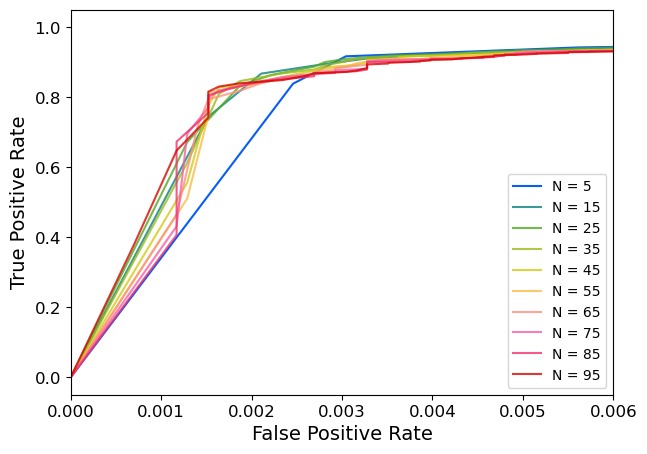

In [31]:
rocx_Knn = []
rocy_Knn = []

plt.figure(figsize=(7,5))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlim(0, 0.006)



for i in range(10):
    Knn = KNeighborsClassifier(Ks[i])
    Knn.fit(X_train4,y_train4)
    yprob4 = Knn.predict_proba(X_test4)
    Knn_roc_x, Knn_roc_y, Knn_thresh = roc_curve(y_test4, yprob4[:,1])
    plt.plot(Knn_roc_x, Knn_roc_y, color=cm[i], label='N = '+str(Ks[i]), alpha=ca[i])
    plt.legend()
    rocx_Knn.append(Knn_roc_x)
    rocy_Knn.append(Knn_roc_y)

**15 neighbors gives a pretty good performance, though almost all number of neighbors do (with the exception of N=5)**

SRT: Again, are you eyeballing this, or do you have a quantitative assessment?

8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance.

In [21]:
from sklearn.tree import DecisionTreeClassifier

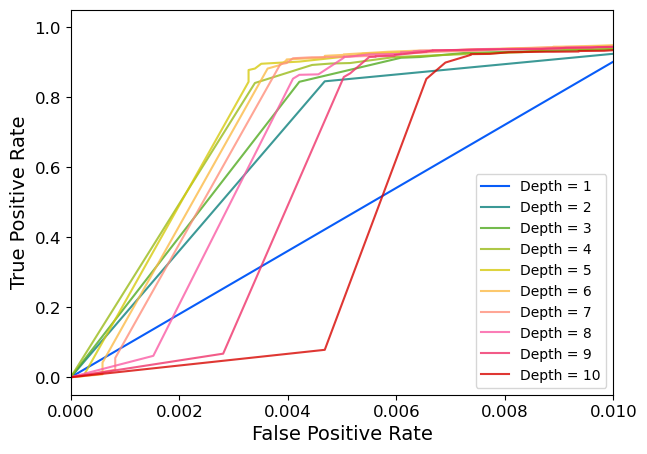

In [22]:
rocx_dt = []
rocy_dt = []

plt.figure(figsize=(7,5))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlim(0, 0.01)


for i in range(10):
    dt = DecisionTreeClassifier(max_depth=i+1)
    dt.fit(X_train4,y_train4)
    yprob4 = dt.predict_proba(X_test4)
    dt_roc_x, dt_roc_y, dt_thresh = roc_curve(y_test4, yprob4[:,1])
    plt.plot(dt_roc_x, dt_roc_y, color=cm[i], label='Depth = '+str(i+1), alpha=ca[i])
    plt.legend()
    rocx_dt.append(dt_roc_x)
    rocy_dt.append(dt_roc_y)

**Depth = 5 gives the best performance**

9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier?

(0.0, 0.01)

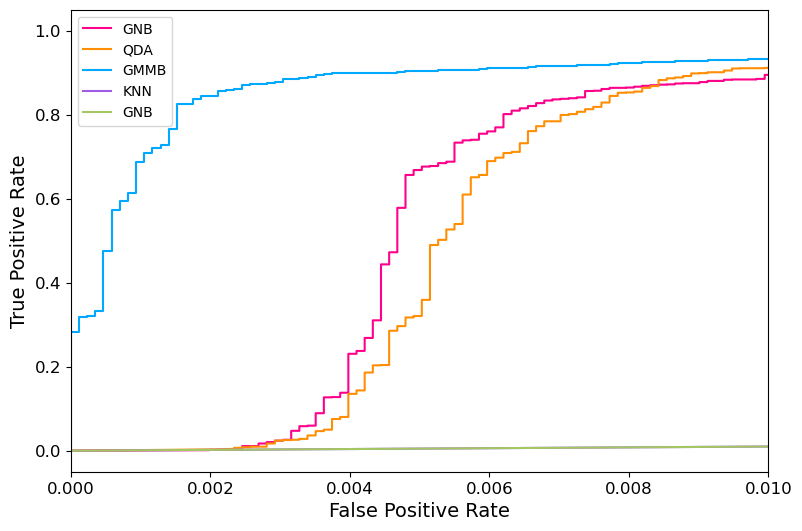

In [30]:
GNB_x = rocx[3]
GNB_y = rocy[3]

QDA_x = rocx_QDA[3]
QDA_y = rocy_QDA[3]

GMMB_x = rocx_gmmb[8]
GMMB_y = rocy_gmmb[8]

KNN_x = rocx_Knn[1]
KNN_y = rocx_Knn[1]

DT_x = rocx_dt[4]
DT_y = rocx_dt[4]


plt.figure(figsize=(9,6))
plt.plot(GNB_x, GNB_y, color=clrs[0], label='GNB')
plt.plot(QDA_x, QDA_y, color=clrs[1], label='QDA')
plt.plot(GMMB_x, GMMB_y, color=clrs[2], label='GMMB')
plt.plot(KNN_x, KNN_y, color=clrs[3], label='KNN')
plt.plot(DT_x, DT_y, color=clrs[4], label='GNB')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend()
plt.xlim(0,0.01)

**Gaussian Mixture Model Bayes wins this one!**

10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier.

In [46]:
gmmb = GMMBayes(9)
gmmb.fit(X_train4,y_train4)
gmmb_pred = gmmb.predict(X_test4)

In [48]:
gmmb_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [49]:
np.shape(y_test4)

(10000,)

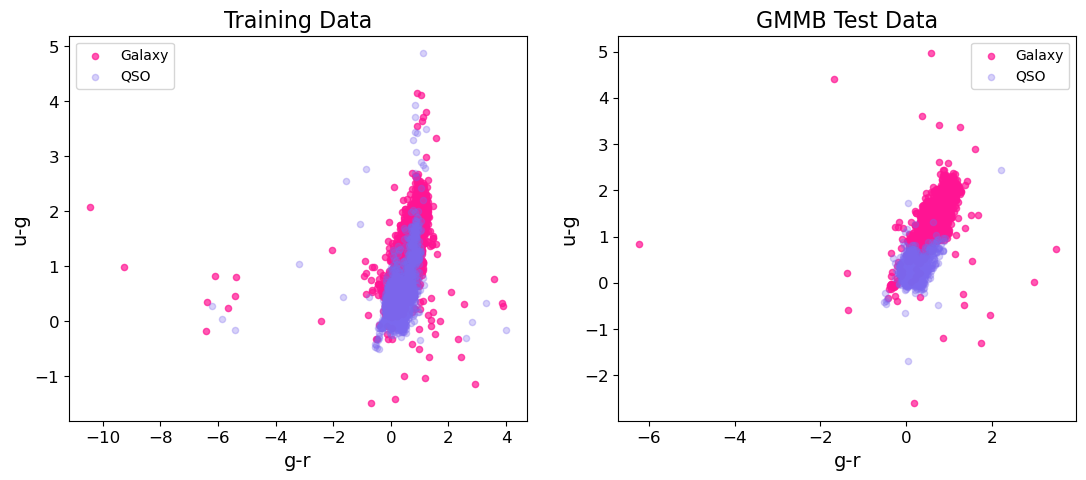

In [53]:
xx = X_train4[:,1]
yy = X_train4[:,0]


xx_ = X_test4[:,1]
yy_ = X_test4[:,0]

fig = plt.figure(figsize=(13,5))
fig.add_subplot(1,2,1)
plt.scatter(xx[y_train4==0], yy[y_train4==0], color='deeppink', alpha=0.7, s=20, label='Galaxy')
plt.scatter(xx[y_train4==1], yy[y_train4==1], color='mediumslateblue', alpha=0.3, s=20, label='QSO')
plt.xlabel('g-r', fontsize=14)
plt.ylabel('u-g', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Training Data', fontsize=16)
plt.legend()


fig.add_subplot(1,2,2)
plt.scatter(xx_[gmmb_pred==0], yy_[gmmb_pred==0], color='deeppink', alpha=0.7, s=20, label='Galaxy')
plt.scatter(xx_[gmmb_pred==1], yy_[gmmb_pred==1], color='mediumslateblue', alpha=0.3, s=20, label='QSO')
plt.xlabel('g-r', fontsize=14)
plt.ylabel('u-g', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('GMMB Test Data', fontsize=16)
plt.legend()

SRT: Well done overall, Sofi.